<a href="https://colab.research.google.com/github/justinetaylor/mids-w207-final-project/blob/yang_branch/clear_cut_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

## Initial Setup
### Import Required Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import os
import re
import warnings
warnings.simplefilter("ignore")

# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer #count up occurences of words
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
# Mount the drive for file storage
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/My Drive/W207-Final-Project')

### Load Data

In [4]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
#preserve testing df ID for submission purpose
test_df_ID = test_df["Id"]

## Feature Engineering 

#### Scale Hillshade

Now we'll normalize the "Hillsdale" variables by dividing them by 255. The hillshade variables contain index of shades with a value between 0 and 255. 

In [5]:
fe1_cols = ['Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm']
train_df[fe1_cols] = train_df[fe1_cols]/255
test_df[fe1_cols] = test_df[fe1_cols]/255

#### Create New Soil Types

Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

In [6]:
def st_fe(df):
    # Create additional features to magnify the differences between cover type 1 and 2
    # Combine soil type 2,18,25,3,36,6,8,28,34 and wildness area 4 as only cover type 2 appers under these features
    df["type2stwa4"] = df["Soil_Type6"] + df["Wilderness_Area4"] +  \
df["Soil_Type2"]+ df["Soil_Type18"] +  df["Soil_Type25"] +  \
df["Soil_Type3"] + df["Soil_Type36"]+ \
df["Soil_Type8"] + df["Soil_Type34"]+ df["Soil_Type28"]

    #Combine soil type 12 and 9 as they appear a lot more under cover type 2 but fewer under cover type 1, none under cover type 5 
    df["st_912"] = df["Soil_Type12"] + df["Soil_Type9"] 

    # Combine soil type 20, 23, 24, 31, 33 and 34 as only cover type 6 appears under these features but not cover type 3.
    df["type6st"] = df["Soil_Type20"] + df["Soil_Type23"]+ \
    df["Soil_Type24"] +  df["Soil_Type31"] + df["Soil_Type33"] +  df["Soil_Type34"]
    return df

In [7]:
# train_df = st_fe(train_df)
# test_df = st_fe(test_df)

#### Drop Non-Existant Soil Types

Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

In [8]:
def drop_soil(df):
    # Remove soil type 7 and 15 due to no data
    df.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)
    # Remove soil type 19, 37, 34, 21, 27,36,28,8,25 due to no limited data - TODO: should we be dropping these? 
    df.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)
    return df

In [9]:
# train_df = drop_soil(train_df)
# test_df = drop_soil(test_df)

#### Combine Similar Soil Types

In [10]:
def st_fe1(df):
    # Combine soil type 35,38,39, 40
    df["soil_type35383940"] = df["Soil_Type38"] +  df["Soil_Type39"] + df["Soil_Type40"] +  df["Soil_Type35"]
    # Combine soil type 10,11, 16, 17
    df["st10111617"] = df["Soil_Type10"] + df["Soil_Type11"] + df["Soil_Type16"] + df["Soil_Type17"]
    # Combine soil type 9, 12
    df["st912"] = df["Soil_Type9"] + df["Soil_Type12"] 
    # Combine soil type 31,33
    df["st3133"] = df["Soil_Type31"] + df["Soil_Type33"]
    # Combine soil type 23, 24
    df["st2324"] = df["Soil_Type23"] + df["Soil_Type24"]
    # Combine soil type 6 and wilderness area 4
    df["st6w4"] = df["Soil_Type6"] + df["Wilderness_Area4"]
#     df.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40','Soil_Type10','Soil_Type11','Soil_Type16','Soil_Type17','Soil_Type9','Soil_Type12','Soil_Type31','Soil_Type33','Soil_Type23','Soil_Type24','Soil_Type6','Wilderness_Area4'], inplace=True)
    return df

In [11]:
# train_df = st_fe1(train_df)
# test_df = st_fe1(test_df)

In [12]:
def st_fe2(df):    
    # pull in the text of the soil types
    with open("km_EDA/soil_raw.txt") as f:
        s_raw = f.read()

    # lowercase everything to make it easier to work with
    s = s_raw.lower()

    # take out punctuation and numbers.
    pattern = re.compile(r"[\d\.,-]")
    s = pattern.sub(" ",s)

    # take out filler words "family","families","complex"
    pattern = re.compile(r"(family|families|complex|typic)")
    s = pattern.sub(" ",s)

    # replace cryaquolis/aquolis (doesn't exist) with cryaquolls/aquolls
    pattern = re.compile(r"aquolis")
    s = pattern.sub("aquolls",s)

    # the "unspecified" row doesn't contain any data
    pattern = re.compile(r"unspecified in the usfs soil and elu survey")
    s = pattern.sub(" ",s)

    #replace the space in words separated by a single space with an underscore
    pattern = re.compile(r"(\w+) (\w+)")
    s = pattern.sub(r"\1_\2",s)



    ### COUNT AND TRANSFORM THE DATA ###
    cv = CountVectorizer()
    # create the counts matrix based on word occurences in our processed soil types
    counts = cv.fit_transform(s.split("\n"))
    # we can use the counts as a transformation matrix to convert to our refined categories
    xform = counts.toarray()

    ## Explanation of xform
        # It turns out that multiplying our original soil matrix by xform using matrix mutiplication
        # will just give us a matrix that has been converted to the new feature space. 

    # Grab out the new features (that are replacing s_01 thru s_40)
    new_cats = cv.get_feature_names()
    print("-- New Feature Names --")
    print(new_cats,"\n")

    # get original soil names
    og_soil_col_names = [("Soil_Type{:d}".format(ii+1)) for ii in range(40)]

    # get columns containing soil information from our dataframe.
    soil_cols = np.array(df[og_soil_col_names])

    # transform the soil features. Put them into a dataframe.
    trans_soil = np.matmul(soil_cols,xform)
    trans_soil_df = pd.DataFrame(data = trans_soil, columns = new_cats)
    display(trans_soil_df)

    ## Remove the features that have very low occurence rates

    # print(trans_soil_df.sum(axis=0))
        # print occurence rates of the various features

    # remove low occurence soil types
    occ_lim = 1400 #0, 2,100,300,900,1400 default # remove columns that have less than occ_lim examples in the data
    high_occ_ser = trans_soil_df.sum(axis=0) >= occ_lim
    high_occ_names = [entry for entry in high_occ_ser.index if high_occ_ser[entry]]
    trans_soil_df = trans_soil_df[high_occ_names]
    display(trans_soil_df)

    # combine the new soil features with the existing freatures in a single df
    df = df.drop(columns=og_soil_col_names)
    df = pd.concat([df, trans_soil_df],axis=1)
    df = df[[col for col in df if col not in ["Cover_Type"]]+["Cover_Type"]] #want cover type as last column
    return df

In [13]:
# train_df = st_fe2(train_df)


#### Transform Aspect 

Now we'll transform the Asepct feature.
TODO: Explain more

In [14]:
def asp_to_vct(df):
    # Convert aspect into sine and cosine values 
    df["ap_ew"] = np.sin(df["Aspect"]/180*np.pi)
    df["ap_ns"] = np.cos(df["Aspect"]/180*np.pi)

    # Drop Aspect column
    df.drop(columns= ["Aspect"], inplace=True)
    return df

In [15]:
train_df = asp_to_vct(train_df)
test_df = asp_to_vct(test_df)

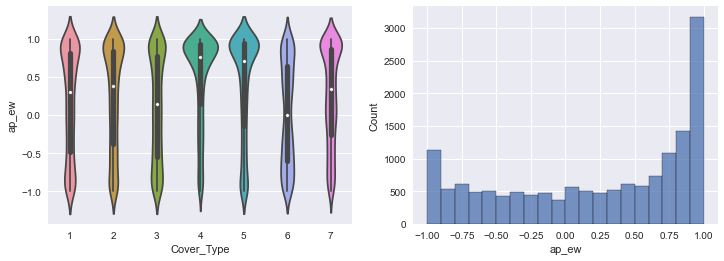

In [16]:
# Visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ew'],ax=ax1)
sns.histplot(train_df['ap_ew'],ax=ax2)
plt.show()

After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types  and the distribution is concentrated around the median. 

#### Log and Polynomial Transformations

Now we'll log transform the features related to the distances.

In [17]:
def log_poly_fe(df):   
     # Complie a list of features to perform log transformation
    fe4_cols = ['Horizontal_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']

    # Add minimum plus 1 to ensure no negative or 0 in the values 
    df[fe4_cols] = df[fe4_cols] +1

    # Log transform
    df[fe4_cols] = np.log(df[fe4_cols])

    # Add a polynominal feature
    df["elv_pwd"] = df["Elevation"]**2
    return df

In [18]:
train_df = log_poly_fe(train_df)
test_df = log_poly_fe(test_df)

#### Drop ID, Hillshade_9am and Vertical Distance.


In [19]:
def drop_fes(df):
    df.drop(columns=["Id","Hillshade_9am","Vertical_Distance_To_Hydrology"],inplace=True)
    return df


In [20]:
train_df = drop_fes(train_df)
test_df = drop_fes(test_df)

In [21]:
#check shape of train and test df
print(train_df.shape)
print(test_df.shape)

(15120, 55)
(565892, 54)


#### Split Data into Train/Dev/Test

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [22]:
# Split training data (labeled) into 80% training and 20% dev) and randomly sample 
training_data = train_df.sample(frac=0.8)
dev_data_df = train_df.drop(training_data.index)

# Examine shape of both data sets
print(training_data.shape)
print(dev_data_df.shape)

# Briefly examine feature attributes for the training data 
training_data.describe()

(12096, 55)
(3024, 55)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,ap_ew,ap_ns,elv_pwd
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,1.209600e+04
mean,2746.681134,16.477927,4.639801,7.123666,0.858550,0.529753,7.056008,0.239583,0.032490,0.416749,...,0.006118,0.000827,0.002315,0.047288,0.042163,0.030671,3.989831,0.227937,0.149691,7.718310e+06
std,417.213688,8.453086,1.812172,0.875025,0.089344,0.179423,0.784037,0.426847,0.177305,0.493041,...,0.077979,0.028742,0.048059,0.212264,0.200969,0.172433,1.995774,0.675251,0.685383,2.313193e+06
min,1863.000000,0.000000,0.000000,0.000000,0.388235,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,3.470769e+06
25%,2376.000000,10.000000,4.219508,6.634633,0.811765,0.418627,6.588926,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-0.374607,-0.500000,5.645376e+06
50%,2748.000000,15.000000,5.198497,7.178545,0.874510,0.541176,7.135687,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.406737,0.275637,7.551504e+06
75%,3101.000000,22.000000,5.802118,7.727315,0.921569,0.654902,7.595890,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.866025,0.809017,9.616201e+06
max,3849.000000,52.000000,7.203406,8.830104,0.996078,0.972549,8.832588,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.481480e+07


In [23]:
# Split into data and labels
train_data = training_data.drop(columns=["Cover_Type"])
train_labels = training_data["Cover_Type"]
dev_data = dev_data_df.drop(columns=["Cover_Type"])
dev_labels = dev_data_df["Cover_Type"]
test_data = test_df

# Double check the shape
print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)

(12096, 54)
(3024, 54)
(565892, 54)


#### Scale Data
Additionally, we will scale the training data to have a mean of 0 and a variance of 1. Then we will retrieve the original training mean and variance for each feature and use that to standardize the development data.

In [24]:
#compile a list for columns for scaling
ss_cols = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points','elv_pwd']

In [25]:
# Normalize features using the standard scaler [training data]
def scaler(ss="",cols=ss_cols):
    if ss == "minmax":
        scaler = MinMaxScaler()
    else :
        scaler = StandardScaler()
        model = scaler.fit(train_data[cols])
    train_data[cols] = model.transform(train_data[cols])
    # Normalize features using the standard scaler [dev data]
    dev_data[cols] = model.transform(dev_data[cols])
    # Normalize features using the standard scaler [test data]
    test_data[cols] = model.transform(test_data[cols])

scaler()

In [26]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}\n".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data.shape, dev_data.shape))
print("Test data shape: ", test_data.shape)

Training data shape: (12096, 54) Training labels shape: (12096,)

Dev data shape: (3024, 54) Dev labels shape: (3024, 54)

Test data shape:  (565892, 54)


## Models
#### Random Forest

Random Forest Performance for 1 trees: 0.578042328042328
Mean Squared Error:  3.4894179894179893
Random Forest Performance for 3 trees: 0.7218915343915344
Mean Squared Error:  2.7609126984126986
Random Forest Performance for 5 trees: 0.7347883597883598
Mean Squared Error:  2.8544973544973544
Random Forest Performance for 10 trees: 0.732473544973545
Mean Squared Error:  2.5949074074074074
Random Forest Performance for 100 trees: 0.748015873015873
Mean Squared Error:  2.4831349206349205


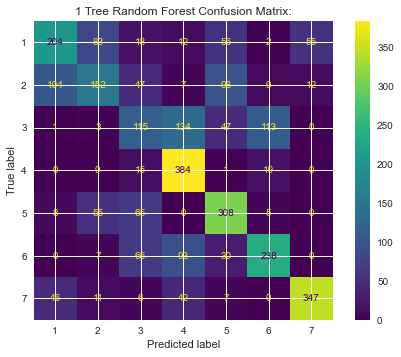

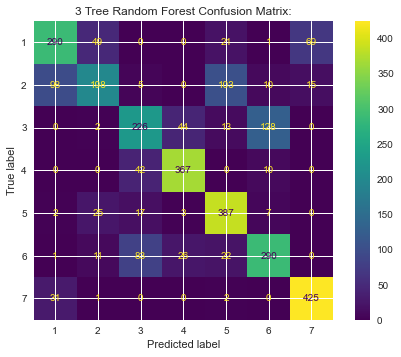

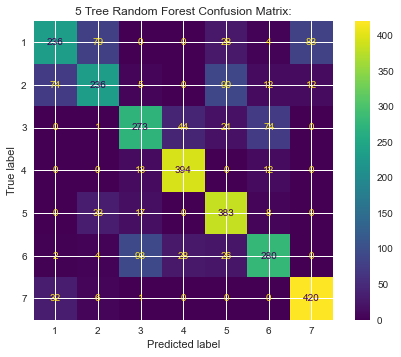

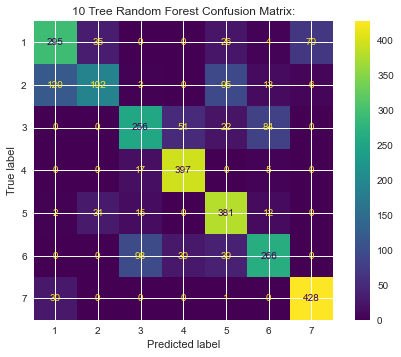

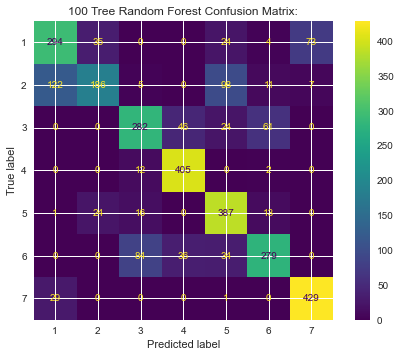

In [27]:
# Try a random forest - before any data cleaning 
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    probabilities = model.predict_proba(dev_data)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    # Plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    mse_forest = mean_squared_error(dev_labels, predictions)
    print("Mean Squared Error: ", mse_forest)
    return score, probabilities
    
num_trees_list = [1,3,5,10,100]
random_forest_results = {}
for num_trees in num_trees_list:
    score, probabilities = RandomForest(num_trees)
    random_forest_results[score] = probabilities

#### Naive Bayes (Bernoulli)

BernoulliNB for alph = 0.01: accuracy = 0.6259920634920635





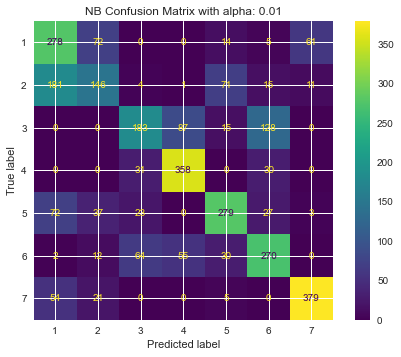

In [28]:
# Try Naive Bayes - Bernoulli 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.8495370370370371
Mean Squared Error:  1.2939814814814814
KNN 2 neighbors : accuracy = 0.8237433862433863
Mean Squared Error:  1.4222883597883598
KNN 4 neighbors : accuracy = 0.8290343915343915
Mean Squared Error:  1.5069444444444444
KNN 7 neighbors : accuracy = 0.8230820105820106
Mean Squared Error:  1.6240079365079365
KNN 10 neighbors : accuracy = 0.8134920634920635
Mean Squared Error:  1.708994708994709


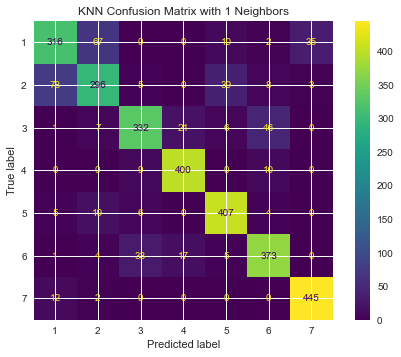

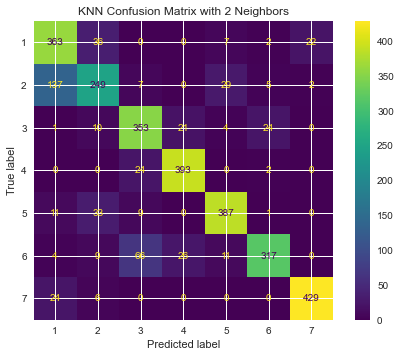

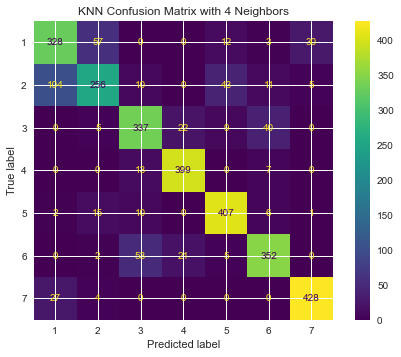

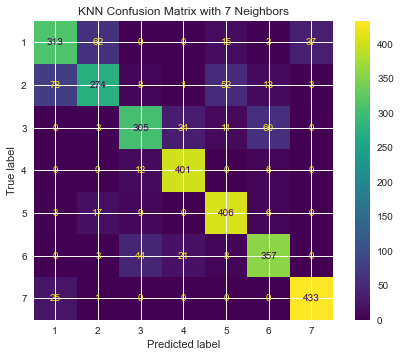

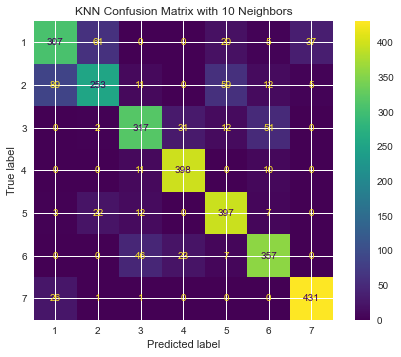

In [29]:
# Try K Nearest Neighbors - before any data cleaning 
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    probabilities = model.predict_proba(dev_data)
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    mse_knn = mean_squared_error(dev_labels, predictions)
    print("Mean Squared Error: ", mse_knn)
    return score, probabilities
    
# The alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
knn_results = {}
for neigh in neigh_list:
    score, probabilities = KNN(neigh)
    knn_results[score] = probabilities 

#### Multi-layer Perceptron

MLP accuracy =  0.8597883597883598
Mean Squared Error:  1.156084656084656


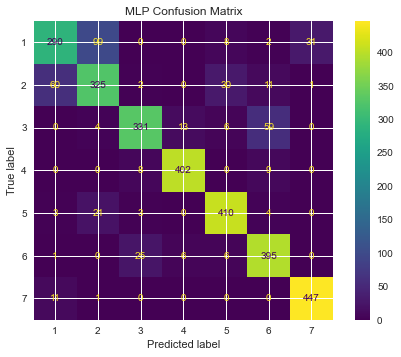

In [30]:
# Try Multi-Layer Perceptron - before any data cleaning 
def MLP():
    #    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
    #    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
    #    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
    #    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(300,), random_state=0, max_iter=500) 
    model.fit(train_data, train_labels) 
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    probabilities = model.predict_proba(dev_data)
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("MLP Confusion Matrix")
    plt.plot()
    print("MLP accuracy = ",score)
    mse_nn = mean_squared_error(dev_labels, predictions)
    print("Mean Squared Error: ", mse_nn)
    y_pred = model.predict(test_data)
        
    return score, probabilities, y_pred

mlp_results = {}
score, probabilities, y_pred = MLP()
mlp_results[score] = probabilities 

#### Logistic Regression

In [31]:
# Logistic regression
def LR():
    model = LogisticRegression(random_state=0, multi_class='ovr',solver='lbfgs', max_iter = 300)
    model.fit(train_data, train_labels)
    score = model.score(dev_data,dev_labels)
    print("Logistic Regression accuracy = ",score)
LR()

Logistic Regression accuracy =  0.7013888888888888


#### Neural Network with Tensorflow

In [32]:
tf.executing_eagerly()

True

In [33]:
train_data[:1].shape
train_data.to_numpy().shape, train_labels.to_numpy().shape

((12096, 54), (12096,))

In [34]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(54,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Retrieve predictions 
predictions = model(train_data[:-1].to_numpy())
# Convert logits to probabilities
tf.nn.softmax(predictions).numpy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(train_data.to_numpy(), train_labels.to_numpy(), epochs=5)


Epoch 1/5
12096/12096 [==============================] - 1s 44us/sample - loss: 1.0794 - acc: 0.6014
Epoch 2/5
12096/12096 [==============================] - 1s 42us/sample - loss: 0.7388 - acc: 0.6907
Epoch 3/5
12096/12096 [==============================] - ETA: 0s - loss: 0.6839 - acc: 0.714 - 0s 40us/sample - loss: 0.6840 - acc: 0.7140
Epoch 4/5
12096/12096 [==============================] - 0s 41us/sample - loss: 0.6544 - acc: 0.7266
Epoch 5/5
12096/12096 [==============================] - 1s 44us/sample - loss: 0.6307 - acc: 0.7323


In [35]:
model.evaluate(dev_data.to_numpy(),  dev_labels.to_numpy(), verbose=2)

3024/3024 - 0s - loss: 0.5926 - acc: 0.7636


[0.5925915487228878, 0.7635582]

#### Generate Submission File

In [36]:
#create submission file.
def gen_sub(y_pred,model="MLP"):
    result = pd.DataFrame.from_dict(dict(zip(test_df_ID.to_list(),y_pred)), orient='index', columns=["Cover_Type"])
    result.to_csv(f"submission{model}.csv",index_label="Id")
gen_sub(y_pred)

#### Ensemble

Here we will combine the three best performing models and implement a "voting" system to try to improve accuracy. 

In [37]:
def Ensemble():
    # Find max score from each model. best_scores shape: (3,)
    best_scores = [max(mlp_results.keys()), max(knn_results.keys()),max(random_forest_results.keys())]
    # Find maximum probability for each example for each model. prediction_probabilities shape: (3024, 3)
    prediction_probabilities = [np.max(mlp_results[best_scores[0]],axis=1),np.max(knn_results[best_scores[1]],axis=1),np.max(random_forest_results[best_scores[2]],axis=1)]
    prediction_probabilities = np.transpose(np.array(prediction_probabilities))
    # Find highest predicted label. predicted_classes shape: (3024, 3)
    predicted_classes = [np.argmax(mlp_results[best_scores[0]],axis=1)+1,np.argmax(knn_results[best_scores[1]],axis=1)+1,np.argmax(random_forest_results[best_scores[2]]+1,axis=1)]
    predicted_classes = np.transpose(np.array(predicted_classes))
    
    # Determine final predictions
    new_predictions = []
    # Keep track of instances in which the models disagree for insight 
    count = 0
    for i, row in enumerate(predicted_classes):
        # Count instances of each class in the predictions
        unique, counts = np.unique(row, return_counts=True)
        zipped = dict(zip(unique, counts))
        # Initialize Classification
        classification = 0
        # If there's only 1 unique value, all models agreed
        if len(unique) == 1:
            classification = unique[0]
        # Two out of three models agreed
        elif len(unique) == 2:
            count += 1
            classification = unique[np.argmax(counts)]
        # All three models disagree. Choose the label with the highest probability 
        else:
            count += 1
            classification = prediction_probabilities[i][0]
        # Assign the new prediction
        new_predictions.append(classification)
    print("Models disagreed on {0}/{1} dev examples.".format(count, dev_labels.shape[0]))
    return predicted_classes, np.array(new_predictions).astype(int)

predicted_classes, new_predictions = Ensemble()
mse_ensemble = mean_squared_error(dev_labels, new_predictions)
accuracy = accuracy_score(dev_labels, new_predictions)
print("Mean Squared Error: ", mse_ensemble)
print("Accuracy: ", accuracy)

Models disagreed on 2967/3024 dev examples.
Mean Squared Error:  2.0955687830687832
Accuracy:  0.8042328042328042


(array([446., 245., 399., 487., 568., 370., 509.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

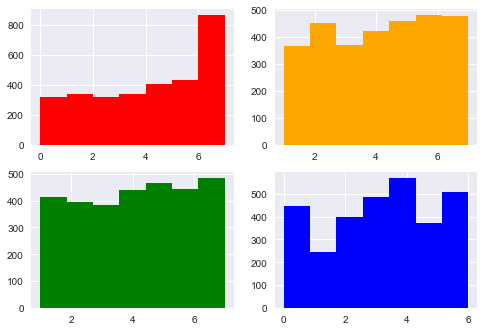

In [38]:
# Examine and Compare Histograms of Predictions
fig, axes = plt.subplots(2,2)
# Ensemble
axes[0,0].hist(new_predictions, bins=7,color = 'red') 
# MLP
axes[0,1].hist(predicted_classes[:,0], bins=7, color = 'orange') 
# KNN
axes[1,0].hist(predicted_classes[:,1], bins=7, color = 'green') 
# Random Forest
axes[1,1].hist(predicted_classes[:,2], bins=7, color = 'blue') 

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [39]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear_cut_solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear_cut_solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear_cut_solution.ipynb --to html --output="backups/clear-cut-solution"

[NbConvertApp] Converting notebook clear_cut_solution.ipynb to python
[NbConvertApp] Writing 21964 bytes to backups\clear-cut-solution.py
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear-cut-solution_files\
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_